In [1]:
import pandas as pd
import os
import numpy as np
import pickle as pkl
import copy
import matplotlib.pyplot as plt
import re
import scipy.stats as st
import copy
import itertools
# from statsmodels.stats.multitest import multipletests
import sys
sys.path.append(os.path.abspath(".."))
from torch import nn
import torch
from statsmodels.stats.multitest import multipletests
import json
import seaborn as sns
from matplotlib.ticker import MultipleLocator

In [7]:
tracking_dict

{('LR', 'Sequences Only'): 'logs/logs_realdata/LR/otus_ibmdb_cts_f1_kfold',
 ('LR',
  'Metabolites + Sequences'): 'logs/logs_realdata/LR/metabs_otus_ibmdb_pubchem_f1_kfold',
 ('LR',
  'Metabolites Only'): 'logs/logs_realdata/LR/metabs_erawijantari_pubchem_f1_kfold',
 ('RF', 'Sequences Only'): 'logs/logs_realdata/RF/otus_ibmdb_cts_f1_kfold',
 ('RF',
  'Metabolites + Sequences'): 'logs/logs_realdata/RF/metabs_otus_ibmdb_pubchem_f1_kfold',
 ('RF',
  'Metabolites Only'): 'logs/logs_realdata/RF/metabs_erawijantari_pubchem_f1_kfold',
 ('AdaBoost',
  'Sequences Only'): 'logs/logs_realdata/AdaBoost/otus_ibmdb_cts_f1_kfold',
 ('AdaBoost',
  'Metabolites + Sequences'): 'logs/logs_realdata/AdaBoost/metabs_otus_ibmdb_pubchem_f1_kfold',
 ('AdaBoost',
  'Metabolites Only'): 'logs/logs_realdata/AdaBoost/metabs_erawijantari_pubchem_f1_kfold',
 ('MMETHANE',
  'Metabolites Only'): {'he, month 2': 'logs/logs_realdata/MMETHANE/he_pubchem/2_mets__F1=0d8441_F1_weighted=0d8836_AUC=0d9506'},
 ('MMETHANE',
  '

In [6]:
fingerprint='pubchem'
mditre_folder = 'logs/logs_realdata/MMETHANE/'
# mditre_folder = '/Users/jendawk/logs/mditre-logs/'
fc_folder = 'logs/logs_realdata/FFN/'
full_fc_case = ['']
folders = [mditre_folder,fc_folder]
dtypes = ['Metabolites Only', 'Metabolites + Sequences','Sequences Only']
# dtypes = ['mets','mets_seqs']
new_case = ['']

# basic_with_logreg = 'BASIC_REDO_LOGREG_11_7_methodbasic_add_logreg1'
old_avoid = ['NO_HOST', '/old/']
# cases = {'Fully-\nconnected NN': full_fc_case,'Our Model':new_case}
# folder_dict ={'Fully-\nconnected NN':fc_folder,'Our Model':mditre_folder}
cases = {'MMETHANE':new_case,'Fully-connected neural network':full_fc_case}
folder_dict ={'MMETHANE':mditre_folder,'Fully-connected neural network':fc_folder}
METHOD_LS = ['MMETHANE',
             'LR','RF','AdaBoost','Fully-connected neural network',]
# nam_case = 'NAM_1013_lr_nam_0d001_monitortrain_loss_validate0_cv_typekfold_kfolds5_early_stopping0_epochs1500_h_sizes0_0'
# nam_case_2 = 'NAM_1013'
# seed_vec = [13,32,39,24,10,78,12,83,54,53]
# seed_vec = [53,34,10,54,24,72,62,37,95,74]
# seed_vec = list(set(range(100))-set([25]))
# seed_vec = [60, 33, 79, 30, 38, 40, 59, 44,  9, 53]
# seed_vec = [60, 30, 38, 33, 79, 14, 77, 59, 40, 12]
seed_vec = list(range(10))
new_lr = 'LR/'
new_rf = 'RF/'
inner_metric = 'f1'
# case_auc = 'roc_auc'

results = {}
METRIC_LS = ['F1_weighted','AUC']
tracking_dict = {}
tm = 'new'
for METRIC in METRIC_LS:
    results[METRIC]={}
    
    for dtype in dtypes:
        results[METRIC][dtype]={}
        for method in METHOD_LS:
            results[METRIC][dtype][method.replace('LR','lasso LR')] = {}
# seqs, f1
comp_lr = ['otus_wang_cts_f1','otus_franzosa_cts_roc_auc',
           'metabs_otus_franzosa_pubchem_f1','metabs_otus_wang_pubchem_f1','metabs_otus_erawijantari_pubchem_f1',
          'metabs_otus_yachida_III_IV_pubchem_roc_auc','metabs_otus_wang_pubchem_roc_auc']

comp_rf = ['metabs_otus_franzosa_pubchem_f1','metabs_otus_yachida_III_IV_pubchem_roc_auc',
          'metabs_otus_franzosa_pubchem_roc_auc','metabs_otus_erawijantari_pubchem_roc_auc']

seed_ls = [f"seed_{i}" for i in seed_vec]
tms = ['new']
for method in ['LR','RF','AdaBoost']:
    folder = f'logs/logs_realdata/{method}/'
    for root, dirs, files in os.walk(folder):
        if any([o in root for o in old_avoid]):
            continue
        if 'SQRT' in root:
            continue
        # if method=='LR' and 'otus' in root and 'SQRT' not in root:
        #     continue
        if '/old' in root or 'pre-feb7' in root:
            continue
#         if 'FINAL' not in root:
#             continue
        if 'res.csv' in files or 'res_2.csv' in files:
            if folder==root:
                continue

            # if method=='LR' and 'otus' in root and 'NoOTU_Transform' not in root:
            #     continue

            if 'week_1' in root and 'loo' not in root:
                continue
            if inner_metric not in root:
                continue
            if 'metabs_otus' in root:
                dtype = 'Metabolites + Sequences'
            elif 'otus' not in root:
                dtype = 'Metabolites Only'
            else:
                dtype = 'Sequences Only'
            # if dtype=='Metabolites Only':
            #     if method=='LR' and 'stand_from_train_data' not in root:
            #         if 'ibmdb' not in root and 'he' not in root:
            #             continue
            # else:
            #     if method=='LR' and 'clr' not in root:
            #         if 'ibmdb' not in root and 'he' not in root and 'REDO_CTS' not in root:
            #             continue
                    # continue
            # dtype = 'mets_seqs' if 'metabs_otus' in root else 'seqs'
            # if dtype=='seqs' and 'otus' not in root:
            #     continue
            dataset = root.split(folder)[-1].split('metabs_')[-1].split('otus_')[-1].split('_cts_')[0].split('_ra_')[0].split('_pubchem')[0].split('_' + inner_metric)[0]
            if dataset=='preterm':
                continue
            if dataset=='he':
                month = root.split('pubchem_')[-1].split('_cts_')[-1].split('_'+inner_metric)[0]
                dataset += ', month ' + month
            if 'res_2.csv' in files:
                tmp = pd.read_csv(os.path.join(root, 'res_2.csv'), index_col=[0]).loc[seed_ls]
            else:
                tmp = pd.read_csv(os.path.join(root, 'res.csv'), index_col=[0]).loc[seed_ls]

            if (method,dtype) not in tracking_dict.keys():
                tracking_dict[(method,dtype)]={}
            tracking_dict[(method,dtype)]=root
            for METRIC in METRIC_LS:
                results[METRIC][dtype][method.replace('LR','lasso LR')][dataset] = tmp[METRIC].values

seed_ls = [f"('seed_{i}',)" for i in seed_vec]
for k,folder in folder_dict.items():
    for root, dirs, files in os.walk(folder):
        if 'results_best.csv' in files or 'results_last.csv' in files:
            dataset = root.split(folder)[-1].split(f'_{fingerprint}')[0].split('_cts')[0].split('_ra')[0].replace('/','')
            if dataset == 'he':
                month = root.split(folder)[-1].split(f'_{fingerprint}/')[-1].split('_cts/')[-1].split('_mets')[0].split('_seqs')[0]
                dataset += ', month ' + month
            rtmp = root.replace('_xdl','')
            if 'mets_seqs' in rtmp or ('mets' in rtmp and 'seqs' in rtmp):
                dtype = 'Metabolites + Sequences'
            elif 'seqs' not in root:
                dtype = 'Metabolites Only'
            else:
                dtype = 'Sequences Only'

            if 'results_last.csv' in files:
                try:
                    tmp = pd.read_csv(os.path.join(root, 'results_last.csv'), index_col=[0]).loc[seed_ls]
                except:
                    tmp = pd.read_csv(os.path.join(root, 'results_last.csv'), index_col=[0]).iloc[:-5,:]

                
                print('')
                # print(folder, root)
                # print(tmp.shape)
                if 'week_1' in root or 'yachida_I_II' in root:
                    continue
                else:
                
                    print(root)
                    va = cases[k]
                    new_va = va.copy()
                    # if k=='MMETHANE' and "Sequences" not in dtype:
                    #     new_va.append('metabs_use_pca1')
                    #     print(new_va)
                    if isinstance(new_va, list):
                        if all([v in root for v in new_va]):
                            for METRIC in METRIC_LS:
                                print(METRIC)
                                print(dtype)
                                print(k)
                                print(dataset)
                                
                                # print(tmp)
                                results[METRIC][dtype][k][dataset] = tmp[METRIC].values
                                print(results[METRIC][dtype][k][dataset])
                                print('')
                                
                                if (k,dtype) not in tracking_dict.keys():
                                    tracking_dict[(k,dtype)]={}
                                        
                                    
                                    tracking_dict[(k,dtype)][dataset] = root
                                # elif dataset in results[METRIC][dtype][k].keys():
                                    # print(f'ERROR! DATASET {dataset} for {k} ALREADY IN KEYS')
                                
                    # else:
                    #     # if va in root:
                    #     for METRIC in METRIC_LS:
                    #         if va in root and dataset not in results[METRIC][dtype][k].keys():
                    #             print(dataset)
                    #             print(dtype)
                    #             results[METRIC][dtype][k][dataset] = tmp[METRIC].values
                    #             if (k,dtype) not in tracking_dict.keys():
                    #                 tracking_dict[(k,dtype)]={}
                                    
                                
                    #             tracking_dict[(k,dtype)][dataset] = root
                    #         # elif dataset in results[METRIC][dtype][k].keys():
                    #         #     print(f'ERROR! DATASET {dataset} for {k} ALREADY IN KEYS')

    


logs/logs_realdata/MMETHANE/he_pubchem/2_mets__F1=0d8441_F1_weighted=0d8836_AUC=0d9506
F1_weighted
Metabolites Only
MMETHANE
he, month 2
[0.928 0.903 0.855 0.88  0.905 0.834 0.903 0.88  0.905 0.88 ]

AUC
Metabolites Only
MMETHANE
he, month 2
[0.954 0.962 0.947 0.964 0.933 0.952 0.971 0.911 0.947 0.952]


logs/logs_realdata/MMETHANE/ibmdb_pubchem/mets__F1=0d4348_F1_weighted=0d728_AUC=0d7643
F1_weighted
Metabolites Only
MMETHANE
ibmdb
[0.737 0.684 0.691 0.723 0.748 0.726 0.776 0.757 0.716 0.741]

AUC
Metabolites Only
MMETHANE
ibmdb
[0.772 0.723 0.729 0.761 0.803 0.736 0.795 0.762 0.788 0.796]


logs/logs_realdata/MMETHANE/cdi_cts/seqs_mets__F1=0d455_F1_weighted=0d6861_AUC=0d69
F1_weighted
Metabolites + Sequences
MMETHANE
cdi
[0.771 0.707 0.604 0.725 0.644 0.715 0.644 0.707 0.658]

AUC
Metabolites + Sequences
MMETHANE
cdi
[0.728 0.739 0.643 0.69  0.658 0.723 0.679 0.708 0.652]


logs/logs_realdata/MMETHANE/franzosa_pubchem/mets__F1=0d6763_F1_weighted=0d8588_AUC=0d8917
F1_weighted
Metabol

In [10]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 80)

Metabolites Only
Metabolites + Sequences


/var/folders/kg/lq54nq416jqg1h8qrw2_tsp80000gn/T/ipykernel_43960/3559882634.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["He et al.","Dawkins et al.",
/var/folders/kg/lq54nq416jqg1h8qrw2_tsp80000gn/T/ipykernel_43960/3559882634.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["He et al.","Dawkins et al.",


Sequences Only


/var/folders/kg/lq54nq416jqg1h8qrw2_tsp80000gn/T/ipykernel_43960/3559882634.py:77: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Erawijantari et al.","Lloyd-Price et al.",


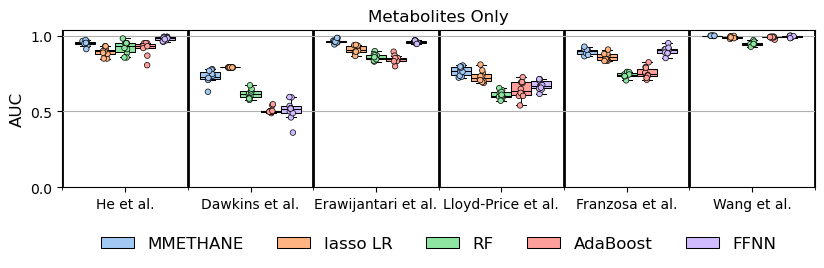

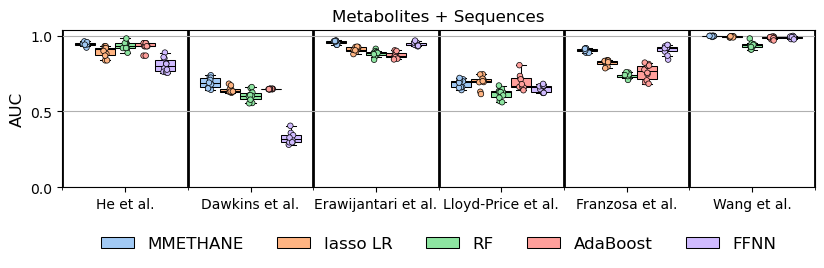

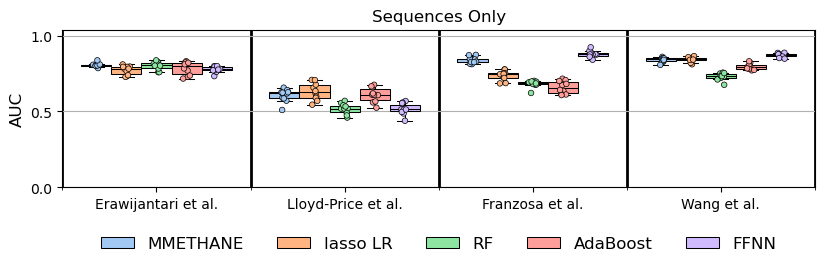

In [10]:
cmap='pastel'
fname = f'final' 
sctest = {'Sequences Only':{},'Metabolites + Sequences':{},'Metabolites Only':{}}
data_out = {d:{METRIC:{} for METRIC in METRIC_LS} for d in ['Metabolites Only','Sequences Only','Metabolites + Sequences']}
df_dict={}
METHOD_LS_ = ['MMETHANE',
             'lasso LR','RF','AdaBoost','Fully-connected neural network']
fnames = ['MMETHANE',
             'lasso LR','RF','AdaBoost','FFNN']

figdata_path = f'figdata/'
for METRIC in ['AUC']:
    df_dict[METRIC]={}
    df_list = []
    append=False
    for dtype in ['Metabolites Only','Metabolites + Sequences', 'Sequences Only']:
        data_ls = []
        method_ls = []
        dd={'medians':{}, '5%':{},'95%':{}}
        print(dtype)
        data={}
        for method in METHOD_LS_:
            dat = results[METRIC][dtype][method]
            res_ls = []
            for k,v in dat.items():
                if dtype == 'Sequences Only' and (k=='he, month 2' or k=='cdi' or k=='he, month f1_kfold'):
                    continue
                if '/' not in k:
                    if len(v)<len(seed_vec):
                        tmp = list(v)
                        tmp.extend([np.median(v)]*(len(seed_vec)-len(v)))
                        v = tmp
                    data[(method,k)]=v
                # res = pd.Series(v, index = [k]*len(v))
                # res_ls.append(res)
        
            dd['medians'][method] = {k:np.median(v) for k,v in dat.items() if 'week_2' not in k}
            dd['5%'][method] = {k:np.percentile(v,5) for k,v in dat.items() if 'week_2' not in k}
            dd['95%'][method] = {k:np.percentile(v,95) for k,v in dat.items() if 'week_2' not in k}
            # tmp = pd.concat(res_ls, axis=0)
            # data[method]=tmp
            # method_ls.extend([method]*tmp.shape[0])
            # data_ls.append(tmp)
            # data[method] = pd.concat(res_ls, axis=0)
        # df = pd.DataFrame(pd.concat(data_ls, axis=0).reset_index(), index = method_ls)
        tb = pd.DataFrame(data)
        tb.index = [METRIC]*tb.shape[0]
        if not os.path.isdir(figdata_path):
            os.mkdir(figdata_path)
        
        with pd.ExcelWriter(figdata_path + '/real_data.xlsx', mode="a", if_sheet_exists="overlay") as writer:
            pd.DataFrame(tb).to_excel(writer, sheet_name=f'{dtype}_{METRIC}')
        stacked = tb.T.stack().reset_index().iloc[:,[0,1,3]]
        stacked.columns = ['Method','Dataset',METRIC]
        fig, ax = plt.subplots(figsize=(8.5,3.25))
        if dtype=='Sequences Only':
            datasets = ['erawijantari','ibmdb','franzosa','wang']
        else:
            datasets = ['he, month 2','cdi','erawijantari','ibmdb','franzosa','wang']
        sns.stripplot(data=stacked, x='Dataset',y=METRIC,hue='Method', dodge=True, legend=False, ax=ax, edgecolor='k',
                      linewidth=0.5, order=datasets, size=4, alpha=1,palette=cmap) 
        f=sns.boxplot(data=stacked, x='Dataset',y=METRIC,hue='Method',ax=ax, showfliers=False,saturation=1, 
                      order=datasets,palette=cmap, linecolor='k', linewidth=0.75)
        handles, _ = f.get_legend_handles_labels()
        f.tick_params(labelsize=10)
        ax.set_ylabel(METRIC, fontsize=12)
        ax.xaxis.set_minor_locator(MultipleLocator(0.5))
        ax.xaxis.grid(True, which='minor', color='black', lw=2)
        # ax.xaxis.set_major_locator(MultipleLocator(0.1))
        ax.yaxis.grid(True) # Hide the horizontal gridlines
        # ax.xaxis.grid(True, which='major', color='gray',lw=0.5)
        ax.set_title(dtype, fontsize=12)
        ax.set_ylim(0,1.04)
        ax.set_yticks([0.0,0.5,1.0])
        ax.set_xlabel('')
        if dtype=='Sequences Only':
            ax.set_xticklabels(["Erawijantari et al.","Lloyd-Price et al.",
                        "Franzosa et al.","Wang et al."])
        else:
            ax.set_xticklabels(["He et al.","Dawkins et al.",
                        "Erawijantari et al.","Lloyd-Price et al.",
                        "Franzosa et al.","Wang et al."])
        f.legend(loc='lower center', bbox_to_anchor=(0.5,-0.5), ncol=len(ax.lines), fontsize=12, 
         frameon=False, handles=handles, labels=fnames)
        # sns.catplot(data=stacked, x='Dataset',y=METRIC,hue='Method', dodge=True, legend=False, ax=ax, edgecolor='k',linewidth=1) 
        # sns.catplot(kind="box",data=stacked, x='Dataset',y=METRIC,hue='Method',ax=ax, showfliers=False,saturation=0.75)
        fig.tight_layout()
        # fig.savefig(f'/Users/jendawk/Dropbox (MIT)/MDITRE-Metabolites Paper/FINAL_FIGURES/Figure2-RealDataResults/Links/{dtype.replace(" ","").replace("+","_")}_{METRIC}.jpeg',
        #             format='jpeg',dpi=600,bbox_inches='tight',pad_inches=0,
        #    transparent=True)

        # fig.show()

        df = pd.DataFrame()
        df.index = pd.DataFrame(dd['medians']).columns.values
        if dtype == 'Sequences Only':
            datasets = ['erawijantari','ibmdb','franzosa','wang']
        else:
            datasets = ['he, month 2','cdi','erawijantari','ibmdb','franzosa','wang']
        dadict = {'he, month 2': 'HE', 'cdi':'DAWKINS', 'erawijantari': 'ERAWIJANTARI','ibmdb':'LLOYD-PRICE','franzosa':'FRANZOSA','wang':'WANG'}
        # df_ls = []
        # for dataset in datasets:
        #     m = np.char.array(pd.DataFrame(dd['medians']).loc[dataset].T.apply(lambda x: np.round(x, 3)))
        #     l = np.char.array(pd.DataFrame(dd['5%']).loc[dataset].T.apply(lambda x: np.round(x, 3)))
        #     u = np.char.array(pd.DataFrame(dd['95%']).loc[dataset].T.apply(lambda x: np.round(x, 3)))
        #     df[f'{dadict[dataset]}'] = (m + b' [' + l + b', ' + u + b']').astype(str)

        # df = df.T
        # if append:
        #     with open(f'{METRIC}_{fname}.csv','a') as f:
        #         df_blank = pd.DataFrame([['']*df.shape[1]])
        #         df_blank.to_csv(f, header=None, index=None)
        #         pd.DataFrame([[dtype]*df.shape[1]]).to_csv(f, header=None, index=None)
        #         df.to_csv(f)
        # else:
        #     with open(f'{METRIC}_{fname}.csv','w') as f:
        #         pd.DataFrame([[dtype]*df.shape[1]]).to_csv(f, header=None, index=None)
        #     with open(f'{METRIC}_{fname}.csv','a') as f:
        #         df.to_csv(f)
            
        #     append=True
        # df_list.append(df)

        # print('')
        # print(df)
        # print('')
        # print('')
        # df_dict[METRIC][dtype]=df

In [ ]:
data_out = {d:{METRIC:{} for METRIC in METRIC_LS} for d in ['Metabolites Only','Sequences Only','Metabolites + Sequences']}
df_dict={}
# methods = ['MMETHANE', 'lasso LR', 'RF', 'AdaBoost', 'Fully-connected neural network']
DTYPES = ['Metabolites Only','Metabolites + Sequences']
datasets = ['he, month 2','cdi','erawijantari','ibmdb','franzosa','wang']
for METRIC in METRIC_LS:
    df_dict[METRIC]={}
    best={}
    sctest = {m:{} for m in METHOD_LS_}
    for method in METHOD_LS_:
        data = {'data':{},'medians':{},'error_l':{},'error_u':{},'5%':{},'95%':{}}
        dd={}
        for dtype in DTYPES:
            dat = results[METRIC][dtype][method]
            dat = {k.replace('_roc','').split('/')[0]:v for k,v in dat.items() if len(v)>0}
            for k,v in dat.items():
                dd[(k,method)] = v
            data['data'][dtype] = dat
            data['medians'][dtype] = {k:np.median(v) for k,v in dat.items() if 'week_2' not in k}
            data['5%'][dtype] = {k:np.percentile(v,5) for k,v in dat.items() if 'week_2' not in k}
            data['95%'][dtype] = {k:np.percentile(v,95) for k,v in dat.items() if 'week_2' not in k}
            
            data['data'][dtype] = dat
            

        keys=[]
        pvals=[]
        d_ls=[]
        for d in datasets:
            keys=[]
            pvals=[]
            d_ls=[]
            try:
                alld = [data['medians'][m][d] for m in data['medians'].keys()]
            except:
                alld = [data['medians'][m][d] for m in ['MMETHANE', 'lasso LR', 'RF', 'AdaBoost']]
            best_dtype = DTYPES[np.argmax(alld)]
            best[d]=best_dtype
            for vs in itertools.combinations(DTYPES, 2):
                if vs[0] == best_dtype or vs[1]==best_dtype:

                # if data['medians'][vs[0]][d]==max(alld) or data['medians'][vs[1]][d]==max(alld):
                # if vs[0]=='MMETHANE' or vs[1]=='MMETHANE':
                    # try:
                    tmp = st.mannwhitneyu(data['data'][vs[0]][d], data['data'][vs[1]][d]) 
                    pvals.append(tmp.pvalue)
                        # keys.append((d,vs[0],vs[1]))
                    # except:
                    #     import pdb; pdb.set_trace()
                    #     print('missing data')
                # d_ls.append(d)
                    keys.append((d,vs[0],vs[1]))

            if len(pvals)>0:
                _, corr, _, _ = multipletests(pvals, alpha=0.1)
            else:
                corr = [np.nan]*len(keys)
            # try:
            for i,k in enumerate(keys):
                if f'{k[1]} vs {k[2]}' not in sctest[method].keys():
                    sctest[method][f'{k[1]} vs {k[2]}']={}
                sctest[method][f'{k[1]} vs {k[2]}'][d]=corr[i]
            # except:
            #     pass
        print(METRIC, method)
        print('\n')
        print(pd.Series(best))
        print(pd.DataFrame(sctest[method]).loc[datasets])
        pd.DataFrame(sctest[method]).loc[datasets].to_csv(figdata_path + f'{METRIC}_{method}_significance.csv')
        print('\n\n\n')
        

        # df = pd.DataFrame()
        # df.index = pd.DataFrame(data['medians']).columns.values

        # df_ls = []
        # for dataset in datasets:
        #     m = np.char.array(pd.DataFrame(data['medians']).loc[dataset].T.apply(lambda x: np.round(x, 3)))
        #     l = np.char.array(pd.DataFrame(data['5%']).loc[dataset].T.apply(lambda x: np.round(x, 3)))
        #     u = np.char.array(pd.DataFrame(data['95%']).loc[dataset].T.apply(lambda x: np.round(x, 3)))
        #     df[f'{dataset}; median {METRIC} [5%, 95%]'] = (m + b' [' + l + b', ' + u + b']').astype(str)
        # print('')
        # print(df)
        # print('')
        # print('')